In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
bag = rosbag.Bag('bag_output_ukf_polban0807_02.bag')

In [4]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil yang bagus-bagus aja
gnss_pos = np.copy(gps_pos[:500])
gnss_t = np.copy(gps_t[:500])
gnss_cov = np.copy(gps_cov[:500])

In [5]:
gps_pos = (-1) * np.copy(gnss_pos[:,:2])
gps_t = np.copy(gnss_t)

# PAKAI OMEGA

In [6]:
f = 100 #Hz
dt = 1/f #s
Tf = 100
var_gps = np.array([[1,0],
                   [0,1]]) * 0.5 **2
var_gps_speed = np.eye(2) * 1.**2
var_gps_yaw = 0.25**2

Q = np.eye(8)
Q[:2,:2] = np.eye(2) * 2.**2
Q[2:4,2:4] = np.eye(2) * 2.**2
Q[4:6,4:6] = np.eye(2) * 0.05**2
Q[6,6] = 1.**2
Q[7,7] = 0.1**2

In [7]:
t = np.array([i*dt for i in range(Tf*f)]) + gps_t[0]

x = np.zeros((f*Tf, 2))
x[0] = gps_pos[0]

v = np.zeros(x.shape)
v[0] = np.array([1., 0.2]) # Tebakan awal
a = np.zeros_like(v) # Tebakan awal

yaw = np.zeros(x.shape[0])
yaw[0] = -2.0
w = np.zeros_like(yaw)
w[0] = 0.05

P = np.zeros((x.shape[0], 8, 8))
P[0, 2:, 2:] = np.eye(6) * 0.1

temp_pos_yaw = np.copy(gps_pos[0])

gps_idx = 1
for i in range(1, x.shape[0]):
    dt = t[i] - t[i-1]

    x[i] = x[i-1] + v[i-1]*dt + a[i-1]*dt**2 / 2
    v[i] = v[i-1] + a[i-1]*dt
    a[i] = np.copy(a[i-1])
    yaw[i] = wrap_angle(yaw[i-1] + w[i-1]*dt)
    w[i] = np.copy(w[i-1])
    
    F = np.eye(8)
    F[:2,2:4] = np.eye(2) * dt
    F[:2,4:6] = np.eye(2) * dt**2 / 2
    F[2:4,4:6] = np.eye(2) * dt
    F[6,-1] = dt
    
    P[i] = F @ P[i-1] @ F.T + Q * dt**2
    
    if (gps_idx != gps_t.shape[0]) and (gps_t[gps_idx] < t[i]):
        dt_gps = gps_t[gps_idx] - gps_t[gps_idx - 1]
        
        # Correct Position
        H = np.zeros((2,8))
        H[:2,:2] = np.eye(2)
        K = P[i] @ H.T @ np.linalg.inv(H@P[i]@H.T + var_gps)
        inno = gps_pos[gps_idx] - x[i]
        
        x[i] = x[i] + K[:2] @ inno
        v[i] = v[i] + K[2:4] @ inno
        a[i] = a[i] + K[4:6] @ inno
        yaw[i] = wrap_angle(yaw[i] + K[6] @ inno)
        w[i] = w[i] + K[7] @ inno
        
        P[i] = (np.eye(8) - K @ H) @ P[i]
        
        # Correct Velocity
        gps_vel = (gps_pos[gps_idx] - gps_pos[gps_idx-1]) / dt_gps
        
        H = np.zeros((2,8))
        H[:2,2:4] = np.eye(2)
        K = P[i] @ H.T @ np.linalg.inv(H@P[i]@H.T + var_gps_speed)
        inno = gps_vel - v[i]
        
        x[i] = x[i] + K[:2] @ inno
        v[i] = v[i] + K[2:4] @ inno
        a[i] = a[i] + K[4:6] @ inno
        yaw[i] = wrap_angle(yaw[i] + K[6] @ inno)
        w[i] = w[i] + K[7] @ inno
        
        P[i] = (np.eye(8) - K @ H) @ P[i]
        
        # Correct Yaw dan Omega
        if np.linalg.norm(gps_vel) <= 1e-4: # If the car doesn't move
            H = np.zeros((1,8))
            H[0, -1] = 1
            K = P[i] @ H.T @ np.linalg.inv(H@P[i]@H.T + 0.05**2)
            inno = np.array([0.0 - w[i]])
            
            x[i] = x[i] + K[:2] @ inno
            v[i] = v[i] + K[2:4] @ inno
            a[i] = a[i] + K[4:6] @ inno
            yaw[i] = wrap_angle(yaw[i] + K[6] @ inno)
            w[i] = w[i] + K[7] @ inno

            P[i] = (np.eye(8) - K @ H) @ P[i]
        else:
            dpos = x[i] - temp_pos_yaw
            gps_yaw  = np.arctan2(dpos[1], dpos[0])
            
            H = np.zeros((1,8))
            H[0, -2] = 1
            K = P[i] @ H.T @ np.linalg.inv(H@P[i]@H.T + var_gps_yaw)
            inno = wrap_angle(np.array([gps_yaw - yaw[i]]))
            
            x[i] = x[i] + K[:2] @ inno
            v[i] = v[i] + K[2:4] @ inno
            a[i] = a[i] + K[4:6] @ inno
            yaw[i] = wrap_angle(yaw[i] + K[6] @ inno)
            w[i] = w[i] + K[7] @ inno

            P[i] = (np.eye(8) - K @ H) @ P[i]
        
        temp_pos_yaw = np.copy(x[i])
        gps_idx += 1

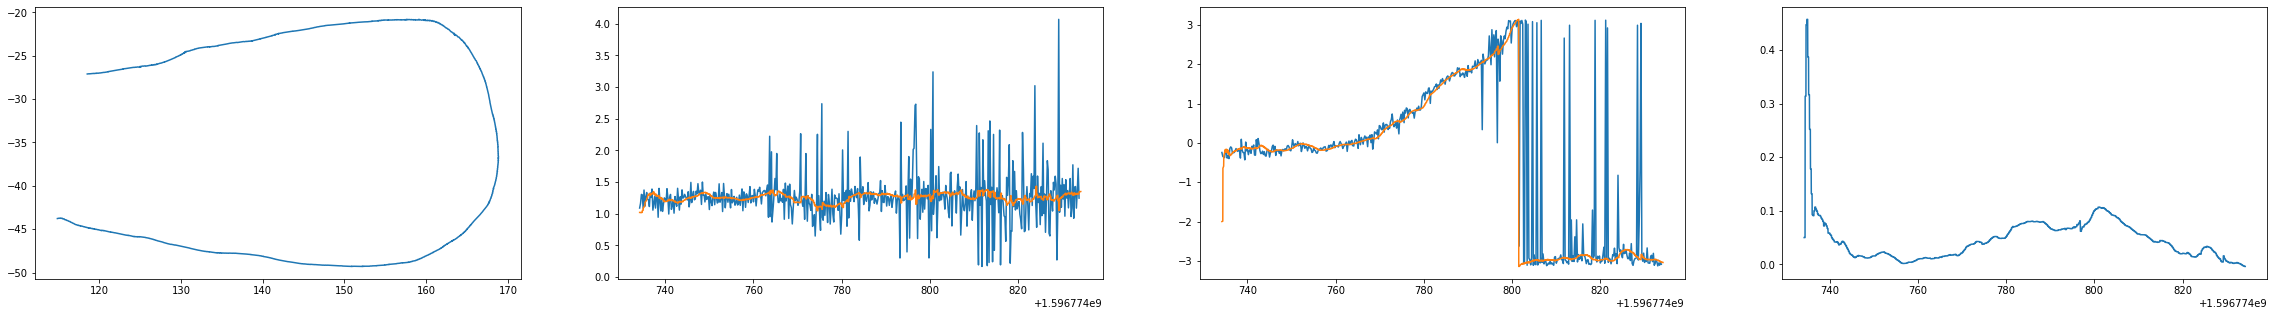

In [8]:
width = 40
height = 5
plt.figure(figsize=(width, height))

plt.subplot(1,4,1)
plt.plot(x[:,0], x[:,1])

plt.subplot(1,4,2)

dgps = gps_pos[1:] - gps_pos[:-1]
v_gps = np.zeros((dgps.shape[0],2))
v_gps[:,0] = dgps[:,0] / (gps_t[1:] - gps_t[:-1])
v_gps[:,1] = dgps[:,1] / (gps_t[1:] - gps_t[:-1])
v_gps_norm = np.linalg.norm(v_gps, axis=-1)

plt.plot(gps_t[:-1], v_gps_norm)
plt.plot(t, np.linalg.norm(v,axis=-1))

plt.subplot(1,4,3)
diff = gps_pos[1:] - gps_pos[:-1]
plt.plot(gps_t[:-1], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(t, yaw)

plt.subplot(1,4,4)
plt.plot(t, w)

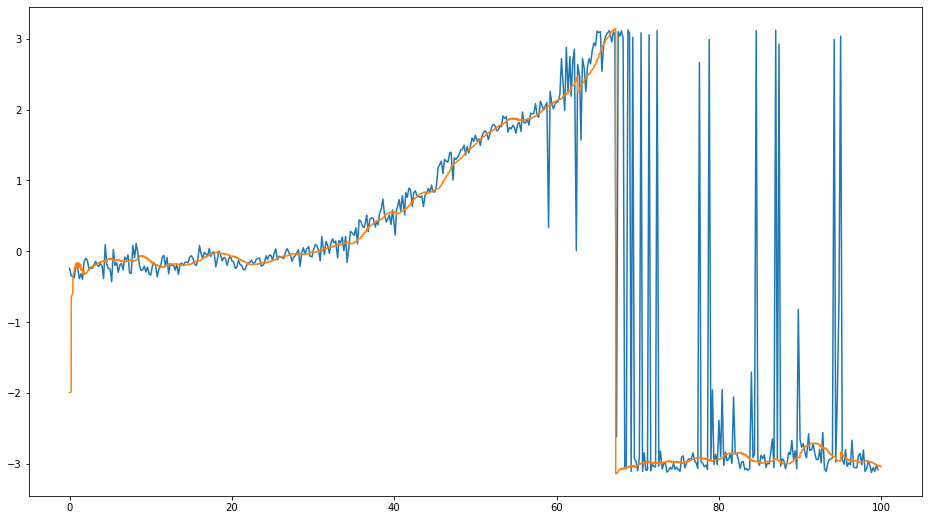

In [9]:
plt.figure(figsize=(16,9))

plt.plot(gps_t[:-1] - gps_t[0], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(t - t[0], yaw)

# PAKAI CLASS KF_gps

In [10]:
from kf_gps import KF_gps

/home/afif/Documents/final_project/final-project/kf_gps/kf_gps.py:12: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec)


Compilling the KF_gps class. Please wait ...


<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))


The KF_gps class has been compiled !


In [11]:
f = 100 #Hz
dt = 1/f #s
Tf = 100
var_gps_pos =  0.5 **2
var_gps_speed = 1. **2
var_gps_yaw = 0.25 **2

Q = np.eye(8)
Q[:2,:2] = np.eye(2) * 2.**2
Q[2:4,2:4] = np.eye(2) * 2.**2
Q[4:6,4:6] = np.eye(2) * 0.05**2
Q[6,6] = 1.**2
Q[7,7] = 0.1**2

t = np.array([i*dt for i in range(Tf*f)]) + gps_t[0]

In [12]:
x = np.zeros((f*Tf, 2))
x[0] = gps_pos[0]

v = np.zeros(x.shape)
v[0] = np.array([1., 0.2]) # Tebakan awal
a = np.zeros_like(v) # Tebakan awal

yaw = np.zeros(x.shape[0])
yaw[0] = -2.0
w = np.zeros_like(yaw)
w[0] = 0.05

P = np.zeros((x.shape[0], 8, 8))
P[0, 2:, 2:] = np.eye(6) * 0.1

temp_pos_yaw = np.copy(gps_pos[0])

kf = KF_gps(var_gps_pos, var_gps_speed, var_gps_yaw, Q,
           x[0], v[0], a[0], yaw[0], w[0], P[0])

gps_idx = 1

In [13]:
for i in range(1, x.shape[0]):
    dt = t[i] - t[i-1]

    x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.predict(dt)
    
    if (gps_idx != gps_t.shape[0]) and (gps_t[gps_idx] < t[i]):
        dt_gps = gps_t[gps_idx] - gps_t[gps_idx - 1]
        
        # Correct Position
        x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_position(gps_pos[gps_idx])
        
        # Correct Velocity
        gps_vel = (gps_pos[gps_idx] - gps_pos[gps_idx-1]) / dt_gps
        x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_velocity(gps_vel)
                
        # Correct Yaw dan Omega
        if np.linalg.norm(gps_vel) <= 1e-4: # If the car doesn't move
            """H = np.zeros((1,8))
            H[0, -1] = 1
            K = P[i] @ H.T @ np.linalg.inv(H@P[i]@H.T + 0.05**2)
            inno = np.array([0.0 - w[i]])
            
            x[i] = x[i] + K[:2] @ inno
            v[i] = v[i] + K[2:4] @ inno
            a[i] = a[i] + K[4:6] @ inno
            yaw[i] = wrap_angle(yaw[i] + K[6] @ inno)
            w[i] = w[i] + K[7] @ inno

            P[i] = (np.eye(8) - K @ H) @ P[i]"""
            pass
        else:
            dpos = x[i] - temp_pos_yaw
            gps_yaw  = np.arctan2(dpos[1], dpos[0])
            x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_yaw(gps_yaw)
        
        temp_pos_yaw = np.copy(x[i])
        gps_idx += 1

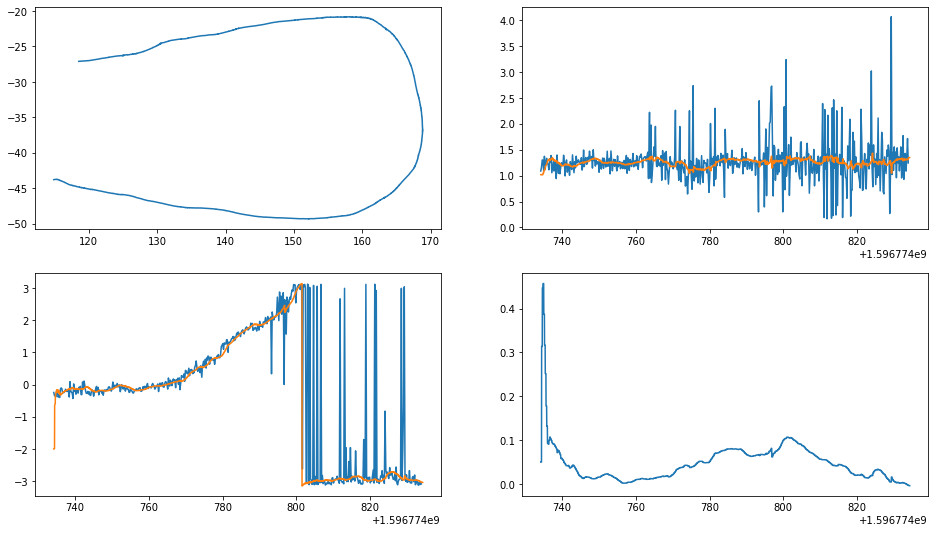

In [14]:
width = 16
height = 9
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(x[:,0], x[:,1])

plt.subplot(2,2,2)

dgps = gps_pos[1:] - gps_pos[:-1]
v_gps = np.zeros((dgps.shape[0],2))
v_gps[:,0] = dgps[:,0] / (gps_t[1:] - gps_t[:-1])
v_gps[:,1] = dgps[:,1] / (gps_t[1:] - gps_t[:-1])
v_gps_norm = np.linalg.norm(v_gps, axis=-1)

plt.plot(gps_t[:-1], v_gps_norm)
plt.plot(t, np.linalg.norm(v,axis=-1))

plt.subplot(2,2,3)
diff = gps_pos[1:] - gps_pos[:-1]
plt.plot(gps_t[:-1], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(t, yaw)

plt.subplot(2,2,4)
plt.plot(t, w)

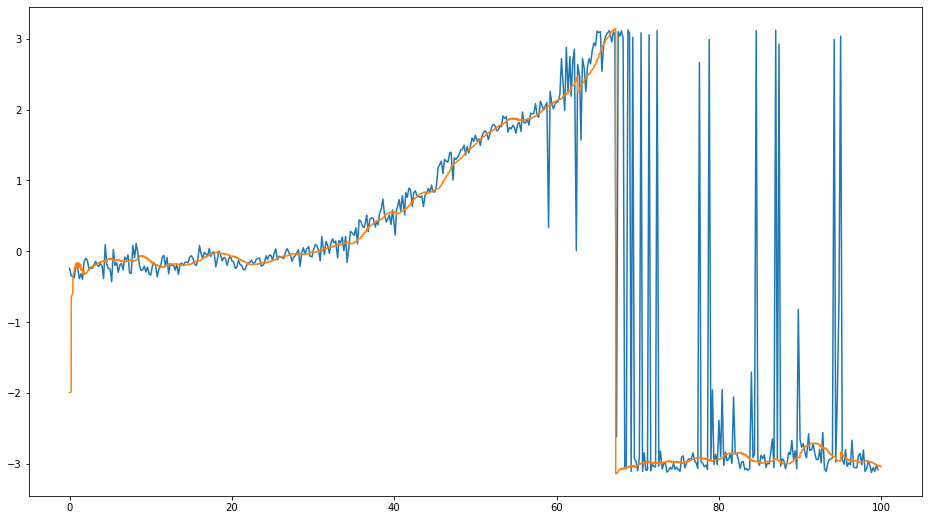

In [15]:
plt.figure(figsize=(16,9))

plt.plot(gps_t[:-1] - gps_t[0], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(t - t[0], yaw)

# NUMBA COMPARISON

In [17]:
# TANPA NUMBA
kf = KF_gps(var_gps_pos, var_gps_speed, var_gps_yaw, Q,
           x[0], v[0], a[0], yaw[0], w[0], P[0])

%timeit x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.predict(dt)

53.2 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
# DENGAN NUMBA
kf = KF_gps(var_gps_pos, var_gps_speed, var_gps_yaw, Q,
           x[0], v[0], a[0], yaw[0], w[0], P[0])

%timeit x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.predict(dt)

7.35 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
